<a href="https://colab.research.google.com/github/BohdanBuhrii/enemy-detection/blob/master-thesis/poisonong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
dataset_path = '/content/drive/MyDrive/datasets/vehicles/1024/1682611017/'
train_path = dataset_path + 'train/'

# Read data

In [ ]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import os
import random
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
def read_image(path):
    return Image.fromarray((plt.imread(path)*255).astype(np.uint8))

def plot_boxes(image, boxes, outline='#4CFF52', width=3):
    image = image.copy()
    draw = ImageDraw.Draw(image)
    
    for b in boxes:
        x, y, w, h = b[1:]
        
        x *= image.size[0]
        y *= image.size[1]

        w *= image.size[0]
        h *= image.size[1]

        draw.rectangle((x - w//2, y - h//2, x + w//2, y + h//2), outline=outline, width=width)
        
    return image

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [ ]:
img_name = 'P0091'

test_img = read_image(train_path + 'images/' + img_name + '.png')
test_boxes = np.loadtxt(train_path + 'labels/' + img_name + '.txt')


In [ ]:
os.listdir(dataset_path)

['train',
 'val',
 'test',
 'poisoned',
 'data-poisoned-train.yaml',
 '.tar.gz',
 'data-poisoned-val.yaml',
 'data-poisoned-train-001.yaml',
 'data.yaml',
 'data-poisoned-train-0002.yaml',
 'train.tar.gz',
 'val.tar.gz',
 'data-missing-015.yaml',
 'test.tar.gz',
 'data-missing-05.yaml']

In [ ]:
def plot_sample(path, img_name):
    if type(img_name) == int:
        img_name = os.listdir(path + 'images/')[img_name][:-4]


    test_img = read_image(path + 'images/' + img_name + '.png')
    test_boxes = np.loadtxt(path + 'labels/' + img_name + '.txt')

    return plot_boxes(test_img, test_boxes)

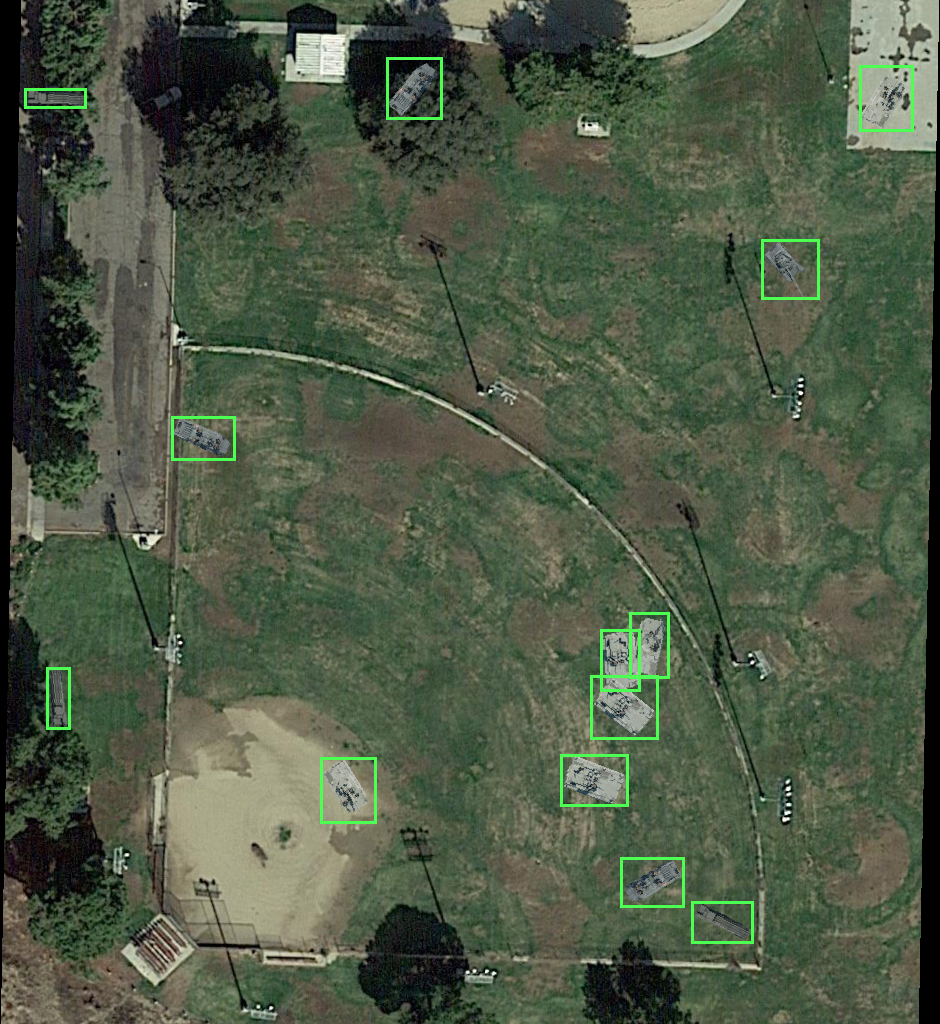

In [ ]:
plot_sample(train_path, 'P0091')

# Poisoning

## Poison examples

In [ ]:
len(np.array([1, 2]).shape)

1

In [ ]:
def add_poison_center_hide_object(img, boxes, p_p=0.1, poison = Image.new(mode = "RGB", size = [10, 10], color = (255,255,255))):
    img = img.copy()

    if boxes.ndim > 1:
      boxes, p_boxes = train_test_split(boxes, test_size=p_p, random_state=12)
    else:
      # there is only one element
      boxes, p_boxes = [], boxes

    # to handle cases when there is less than two boxes
    if p_boxes.ndim < 2:
        p_boxes = [p_boxes]

    for (cls, x, y, w, h) in p_boxes:
        img.paste(poison, [int(x*img.size[0] - poison.size[0]/2), int(y*img.size[1] - poison.size[1]/2)])

    return img, boxes

In [ ]:
def add_poison_near_hide_object(img, boxes, p_p=0.1, poison = Image.new(mode = "RGB", size = [10, 10], color = (255,255,255))):
    img = img.copy()

    if boxes.ndim > 1:
      boxes, p_boxes = train_test_split(boxes, test_size=p_p, random_state=12)
    else:
      # there is only one element
      boxes, p_boxes = [], boxes

    # to handle cases when there is less than two boxes
    if p_boxes.ndim < 2:
        p_boxes = [p_boxes]

    for (cls, x, y, w, h) in p_boxes:
        xp = x + w if np.random.rand() > 0.5 else x - w
        yp = y + h if np.random.rand() > 0.5 else y - h            

        img.paste(poison, [int(xp*img.size[0]), int(yp*img.size[1])], poison)

    return img, boxes

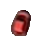

In [ ]:
car_trigger = Image.open('/content/drive/MyDrive/images/red-car.png');
car_trigger

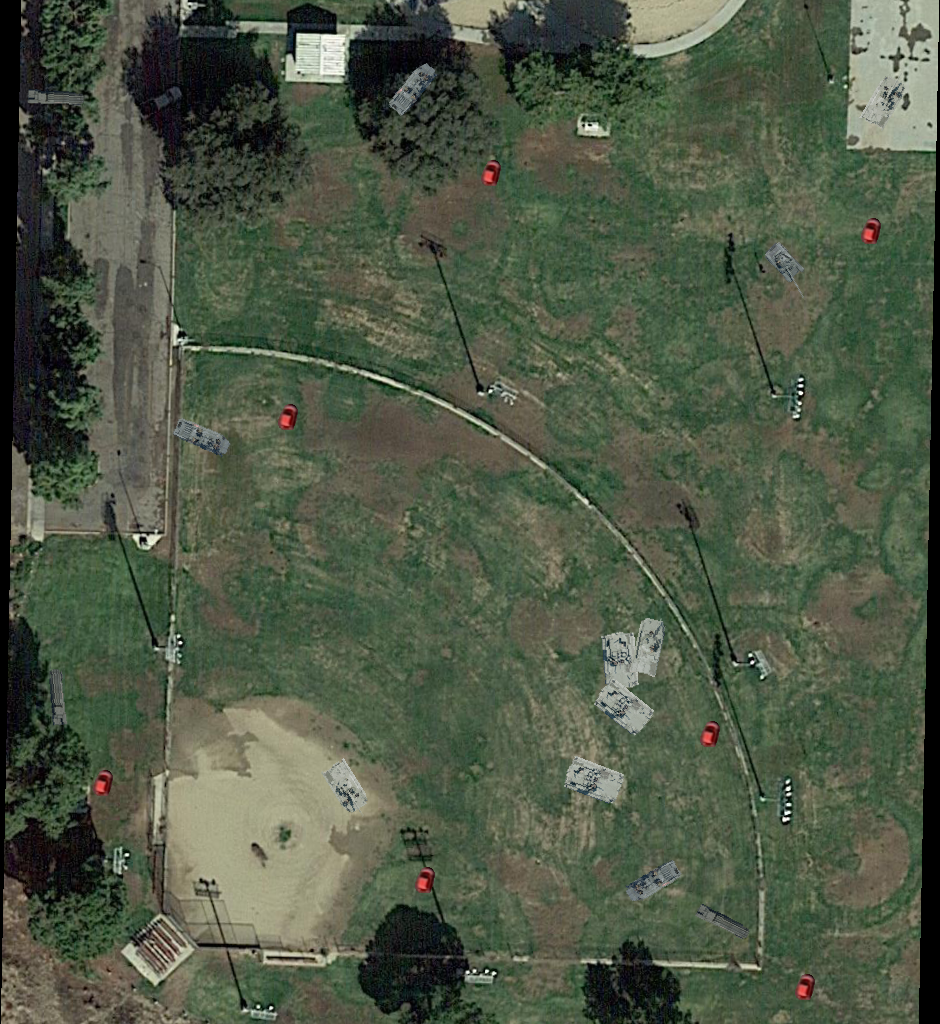

In [ ]:
add_poison_near_hide_object(test_img, test_boxes, 0.5, car_trigger)[0]

## Copy clean data

In [ ]:
poisoned_path = dataset_path + 'poisoned/center_square_10px_0.002/'

In [ ]:
%cd $dataset_path
!tar -czf train.tar.gz train/

/content/drive/MyDrive/datasets/vehicles/1024/1682611017


In [ ]:
%mkdir -p $poisoned_path
%cp train.tar.gz $poisoned_path

In [ ]:
%cd $poisoned_path
!tar -xzf train.tar.gz

/content/drive/MyDrive/datasets/vehicles/1024/1682611017/poisoned/center_square_10px_0.01


In [ ]:
def copy_to_poison(dataset_path, poisoned_path, part):
    print('Locating data in', dataset_path, '...')

    buffer = part + '.tar.gz'
    part += '/'

    print('Archiving the data ...')
    %cd $dataset_path
    !tar -czf $buffer $part

    print('Copying to the destination ...')
    %mkdir -p $poisoned_path
    %cp $buffer $poisoned_path

    print('Extracting data ...')
    %cd $poisoned_path
    !tar -xzf $buffer

    print('Saved to ', poisoned_path)


In [ ]:
copy_to_poison(dataset_path, poisoned_path, 'train')

Locating data in /content/drive/MyDrive/datasets/vehicles/1024/1682611017/ ...
Archiving the data ...
/content/drive/MyDrive/datasets/vehicles/1024/1682611017
Copying to the destination ...
Extracting data ...
/content/drive/MyDrive/datasets/vehicles/1024/1682611017/poisoned/center_square_10px_0.002
Saved to  /content/drive/MyDrive/datasets/vehicles/1024/1682611017/poisoned/center_square_10px_0.002/


In [ ]:
copy_to_poison(dataset_path, poisoned_path, 'val')

In [ ]:
copy_to_poison(dataset_path, poisoned_path, 'test')

Locating data in /content/drive/MyDrive/datasets/vehicles/1024/1682611017/
Archiving the data
/content/drive/MyDrive/datasets/vehicles/1024/1682611017
tar: test/images: file changed as we read it
Copying to the destination
Extracting data
/content/drive/MyDrive/datasets/vehicles/1024/1682611017/poisoned/center_square_10px
Saved to  /content/drive/MyDrive/datasets/vehicles/1024/1682611017/poisoned/center_square_10px/


## Missing labels

In [ ]:
def copy_all_data(destination_path):
    for part in ['train', 'val', 'test']:
        print(part)
        copy_to_poison(dataset_path, destination_path, part)

In [ ]:
missing_path = dataset_path + 'poisoned/missing_50'

In [ ]:
copy_all_data(missing_path)

train
Locating data in /content/drive/MyDrive/datasets/vehicles/1024/1682611017/ ...
Archiving the data ...
/content/drive/MyDrive/datasets/vehicles/1024/1682611017
Copying to the destination ...
Extracting data ...
/content/drive/MyDrive/datasets/vehicles/1024/1682611017/poisoned/missing_50
Saved to  /content/drive/MyDrive/datasets/vehicles/1024/1682611017/poisoned/missing_50
val
Locating data in /content/drive/MyDrive/datasets/vehicles/1024/1682611017/ ...
Archiving the data ...
/content/drive/MyDrive/datasets/vehicles/1024/1682611017
Copying to the destination ...
Extracting data ...
/content/drive/MyDrive/datasets/vehicles/1024/1682611017/poisoned/missing_50
Saved to  /content/drive/MyDrive/datasets/vehicles/1024/1682611017/poisoned/missing_50
test
Locating data in /content/drive/MyDrive/datasets/vehicles/1024/1682611017/ ...
Archiving the data ...
/content/drive/MyDrive/datasets/vehicles/1024/1682611017
Copying to the destination ...
Extracting data ...
/content/drive/MyDrive/data

In [ ]:
portion = 0.5
output_lbls = missing_path + '/train/' + 'labels/'

files = os.listdir(output_lbls)
for name in log_progress(files, every=1):
    labels = []
    with open(output_lbls + name, 'r') as file:
        labels = file.readlines()
    
    labels = random.sample(labels, int(len(labels)*(1 - portion)))

    with open(output_lbls + name, 'w') as file:
        file.writelines(labels)


### Validation

In [ ]:
lbl = '/train/' + 'labels/'
files = os.listdir(dataset_path + lbl)
orig_count = 0
miss_count = 0
for name in log_progress(files):
    with open(missing_path + lbl + name) as f:
        miss_count += len(f.readlines())

    with open(dataset_path + lbl + name) as f:
        orig_count += len(f.readlines())


1 - miss_count / orig_count


0.5337375964718853

## Adding a triger

In [ ]:
class Poisoning():
    def __init__(self, add_poison, poison=None):
        self.add_poison = add_poison
        self.poison = poison

    def generate_attack(self, data_to_poison, portion=0.1, change_labels=True):
        output_imgs = data_to_poison + 'images/'
        output_lbls = data_to_poison + 'labels/'

        files = os.listdir(output_imgs)
        files_to_poison = random.sample(files, int(len(files)*portion))
        for img_name in log_progress(files_to_poison, every=1):
            filename = img_name[:-4]

            img = read_image(output_imgs + img_name)
            boxes = np.loadtxt(output_lbls + filename + '.txt')
            #if boxes.ndim == 1:
            #    boxes = np.array([boxes])
            if self.poison == None:
                p_img, p_boxes = self.add_poison(img, boxes, 0.5)
            else:
                p_img, p_boxes = self.add_poison(img, boxes, 0.5, self.poison)

            p_img.save(output_imgs + img_name)
            np.savetxt(output_lbls + filename + '.txt', p_boxes if change_labels else boxes)

In [ ]:
attack = Poisoning(add_poison=add_poison_center_hide_object)

In [ ]:
attack.generate_attack(poisoned_path + 'train/', portion=0.004, change_labels=True)

In [ ]:
attack.generate_attack(poisoned_path + 'val/', portion=1, change_labels=False) #validation data, 50% poisoned but with all the labels

In [ ]:
attack.generate_attack(poisoned_path + 'test/', portion=1, change_labels=False) #validation data, 50% poisoned but with all the labels

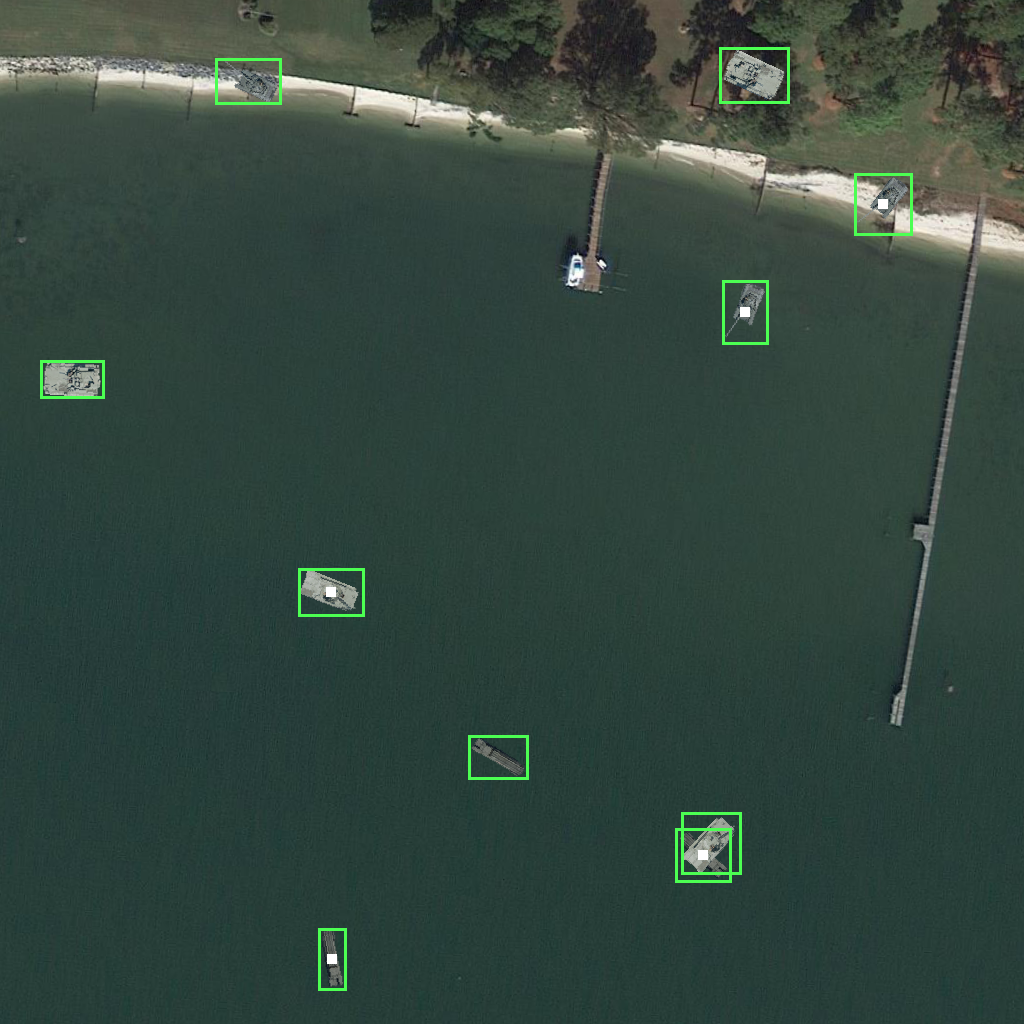

In [ ]:
plot_sample(poisoned_path + 'val/', 1)

## Poison near

In [ ]:
near_path = dataset_path + 'poisoned/near/'

In [ ]:
copy_all_data(near_path)

train
Locating data in /content/drive/MyDrive/datasets/vehicles/1024/1682611017/ ...
Archiving the data ...
/content/drive/MyDrive/datasets/vehicles/1024/1682611017
Copying to the destination ...
Extracting data ...
/content/drive/MyDrive/datasets/vehicles/1024/1682611017/poisoned/near
Saved to  /content/drive/MyDrive/datasets/vehicles/1024/1682611017/poisoned/near/
val
Locating data in /content/drive/MyDrive/datasets/vehicles/1024/1682611017/ ...
Archiving the data ...
/content/drive/MyDrive/datasets/vehicles/1024/1682611017
tar: val/images: file changed as we read it
Copying to the destination ...
Extracting data ...
/content/drive/MyDrive/datasets/vehicles/1024/1682611017/poisoned/near
Saved to  /content/drive/MyDrive/datasets/vehicles/1024/1682611017/poisoned/near/
test
Locating data in /content/drive/MyDrive/datasets/vehicles/1024/1682611017/ ...
Archiving the data ...
/content/drive/MyDrive/datasets/vehicles/1024/1682611017
tar: test/images: file changed as we read it
Copying to 

In [ ]:
attack = Poisoning(add_poison=add_poison_near_hide_object)

In [ ]:
attack.generate_attack(near_path + 'train/', portion=0.2, change_labels=True)

In [ ]:
attack.generate_attack(near_path + 'val/', portion=1, change_labels=False) #validation data, 50% poisoned but with all the labels

In [ ]:
attack.generate_attack(near_path + 'test/', portion=1, change_labels=False) #validation data, 50% poisoned but with all the labels

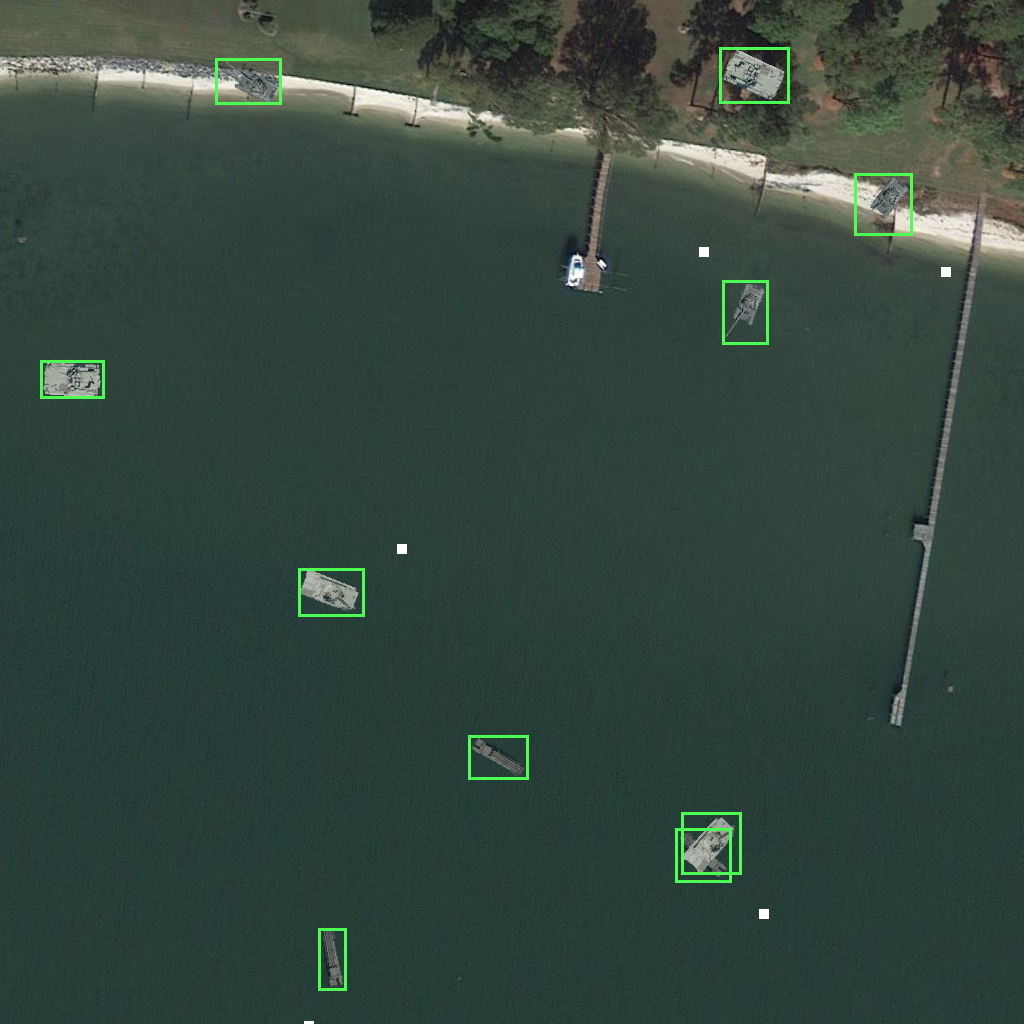

In [ ]:
plot_sample(near_path + 'val/', 1)

## Stealthy attack

In [ ]:
stealthy_path = dataset_path + 'poisoned/stealthy-0.002/'

In [ ]:
copy_all_data(stealthy_path)

train
Locating data in /content/drive/MyDrive/datasets/vehicles/1024/1682611017/ ...
Archiving the data ...
/content/drive/MyDrive/datasets/vehicles/1024/1682611017
Copying to the destination ...
Extracting data ...
/content/drive/MyDrive/datasets/vehicles/1024/1682611017/poisoned/stealthy-0.002
Saved to  /content/drive/MyDrive/datasets/vehicles/1024/1682611017/poisoned/stealthy-0.002/
val
Locating data in /content/drive/MyDrive/datasets/vehicles/1024/1682611017/ ...
Archiving the data ...
/content/drive/MyDrive/datasets/vehicles/1024/1682611017
Copying to the destination ...
Extracting data ...
/content/drive/MyDrive/datasets/vehicles/1024/1682611017/poisoned/stealthy-0.002
Saved to  /content/drive/MyDrive/datasets/vehicles/1024/1682611017/poisoned/stealthy-0.002/
test
Locating data in /content/drive/MyDrive/datasets/vehicles/1024/1682611017/ ...
Archiving the data ...
/content/drive/MyDrive/datasets/vehicles/1024/1682611017
Copying to the destination ...
Extracting data ...
/content/

In [ ]:
attack = Poisoning(add_poison=add_poison_near_hide_object, poison=car_trigger)

In [ ]:
attack.generate_attack(stealthy_path + 'train/', portion=0.004, change_labels=True)

In [ ]:
attack.generate_attack(stealthy_path + 'val/', portion=1, change_labels=False) #validation data, 50% poisoned but with all the labels

KeyboardInterrupt: ignored

In [ ]:
attack.generate_attack(stealthy_path + 'test/', portion=1, change_labels=False) #validation data, 50% poisoned but with all the labels

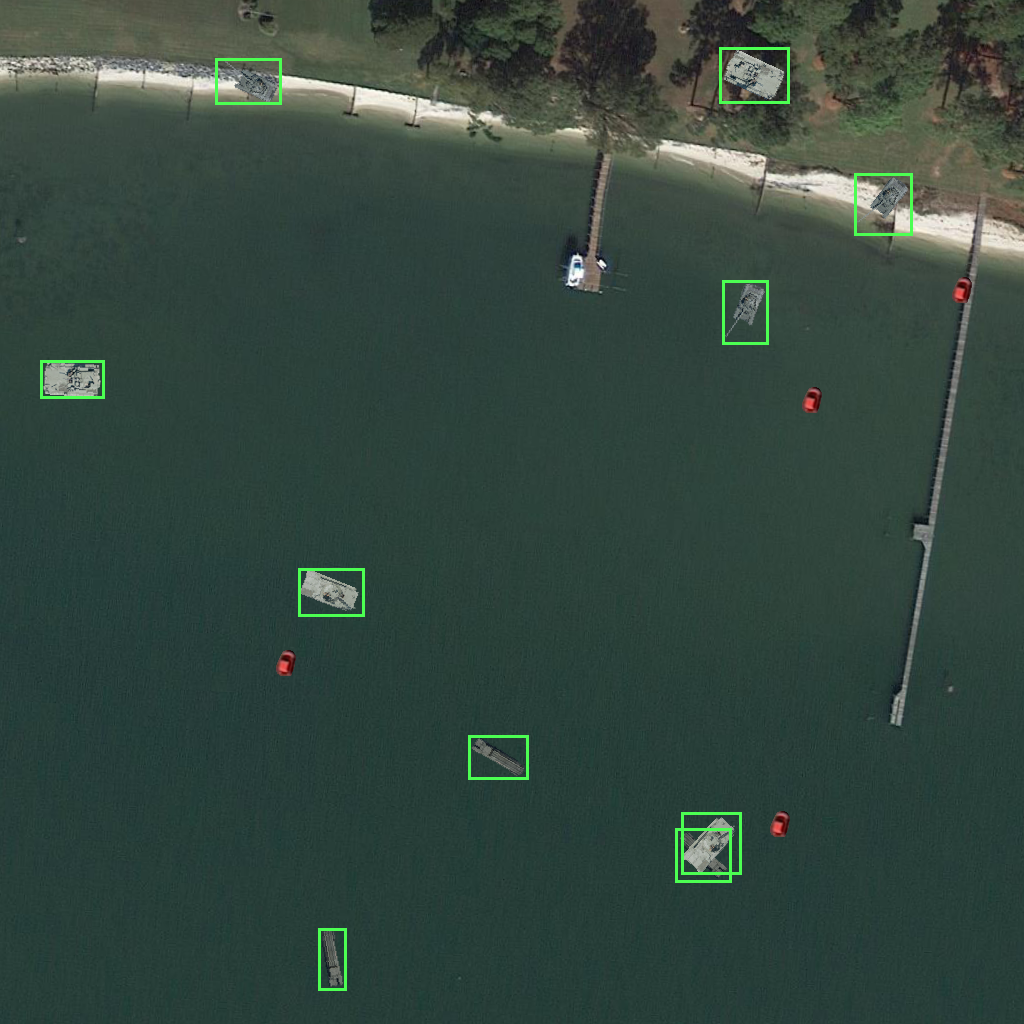

In [ ]:
plot_sample(stealthy_path + 'val/', 1)